In [1]:
"""
diffusion_equation.ipynb

Created on Mon Apr 3 2023

@author: Lukas

This notebook contains all experiments on the Diffusion Equation from this 
(https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html) DeepXDE demo.
"""

'\ndiffusion_equation.ipynb\n\nCreated on Mon Apr 3 2023\n\n@author: Lukas\n\nThis notebook contains all experiments on the Diffusion Equation from this \n(https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html) DeepXDE demo.\n'

In this notebook, we solve the diffusion equation
$$\frac{\delta y}{\delta t} = \frac{\delta^2 y}{\delta x^2} - e^{-t} \left( \sin (\pi x) - \pi^2 \sin (\pi x) \right) $$

for $x in [-1, 1]$ and $t \in [0, 1]$ with the initial condition $y(x, 0) = \sin (\pi x)$ and the Dirichlet boundary condition $y(-1, t) = y(1, t) = 0$. The reference solution is $y = e^{-t} \sin (\pi x)$. We use $t \in [0, 0.5]$ as the temporal training domain and consider $t \in (0.5, 1]$ as the extrapolation area.

In [2]:
# install DeepXDE

%pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 14.6 MB/s eta 0:00:00


In [3]:
# import packages

import deepxde as dde
import numpy as np

from deepxde.backend import tf

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import random

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



In [4]:
# set up the problem

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    return (
        dy_t
        - dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0.5, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

In [5]:
# set up the model

layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.057792 s



/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.318460 s



Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


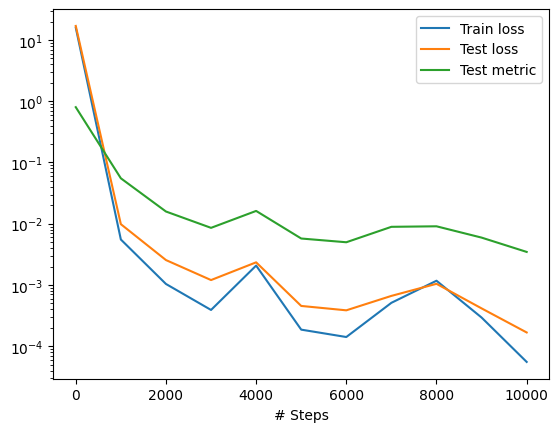

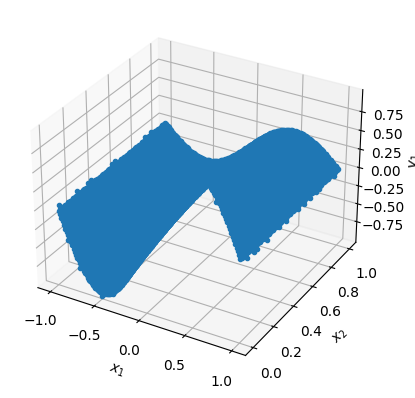

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [6]:
zero_predictions = []
half_predictions = []
one_predictions = []

In [7]:
# predict the solution at t = 0 for x in [-1, 1]

for i in range(15):
    model.train(iterations=2000)

    x = geom.uniform_points(256, True)
    t = np.zeros((256, 1))
    x = np.concatenate([x, t], 1)
    y = model.predict(x)
    zero_predictions.append(y)

    x = geom.uniform_points(256, True)
    t = np.full(256, 0.5)
    x = np.hstack((x, t.reshape(-1, 1)))
    y = model.predict(x)
    half_predictions.append(y)

    x = geom.uniform_points(256, True)
    t = np.full(256, 1.0)
    x = np.hstack((x, t.reshape(-1, 1)))
    y = model.predict(x)
    one_predictions.append(y)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [7.55e+00, 7.02e-02, 3.08e-01]    [9.22e+00, 7.02e-02, 3.08e-01]    [1.41e+00]    
1000      [9.73e-04, 7.94e-04, 1.36e-04]    [2.17e-03, 7.94e-04, 1.36e-04]    [4.45e-02]    
2000      [2.09e-04, 1.86e-04, 4.54e-05]    [8.68e-04, 1.86e-04, 4.54e-05]    [2.08e-02]    

Best model at step 2000:
  train loss: 4.40e-04
  test loss: 1.10e-03
  test metric: [2.08e-02]

'train' took 8.368815 s

Training model...

Step      Train loss                        Test loss                         Test metric   
2000      [2.09e-04, 1.86e-04, 4.54e-05]    [8.68e-04, 1.86e-04, 4.54e-05]    [2.08e-02]    
3000      [4.81e-04, 1.64e-04, 4.55e-05]    [7.57e-04, 1.64e-04, 4.55e-05]    [2.13e-02]    
4000      [9.40e-05, 1.28e-04, 3.11e-05]    [4.66e-04, 1.28e-04, 3.11e-05]    [1.65e-02]    

Best model at step 4000:
  train loss: 2.53e-04
  test loss: 6.25e-0

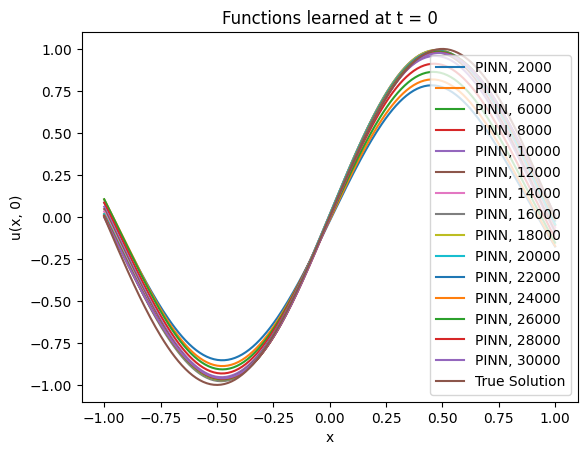

In [8]:
# plot the solution and compare it to the sine function

for i in range(len(zero_predictions)):
    plt.plot(x[:, 0], zero_predictions[i][:, 0], label="PINN, " + str((i+1) * 2000))

plt.plot(x[:, 0], np.exp(0) * np.sin(np.pi * x[:, 0]), label="True Solution")
plt.legend()
plt.title("Functions learned at t = 0")
plt.xlabel("x")
plt.ylabel("u(x, 0)")
plt.show()

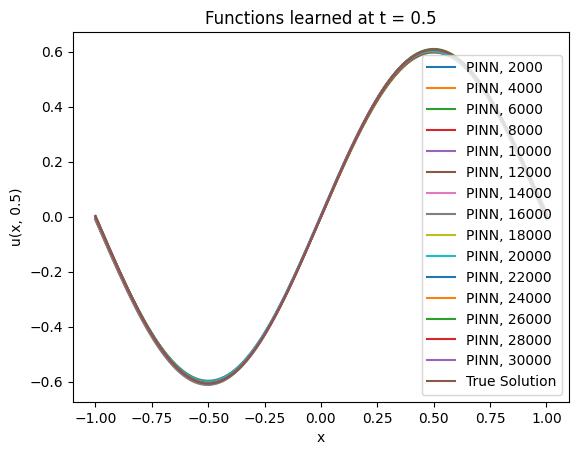

In [9]:
# plot the solution

for i in range(len(half_predictions)):
    plt.plot(x[:, 0], half_predictions[i][:, 0], label="PINN, " + str((i+1) * 2000))

plt.plot(x[:, 0], np.exp(-0.5) * np.sin(np.pi * x[:, 0]), label="True Solution")
plt.legend()
plt.title("Functions learned at t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x, 0.5)")
plt.show()

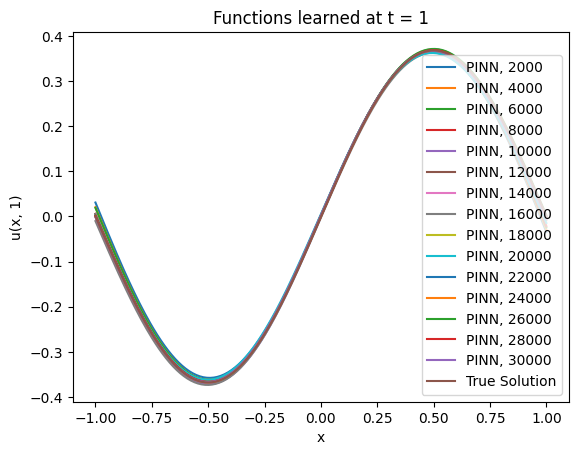

In [15]:
# plot the solution

for i in range(len(one_predictions)):
    plt.plot(x[:, 0], one_predictions[i][:, 0], label= ("PINN, " + str((i+1) * 2000)))

plt.plot(x[:, 0], np.exp(-1) * np.sin(np.pi * x[:, 0]), label="True Solution")
plt.legend()
plt.title("Functions learned at t = 1")
plt.xlabel("x")
plt.ylabel("u(x, 1)")
plt.show()

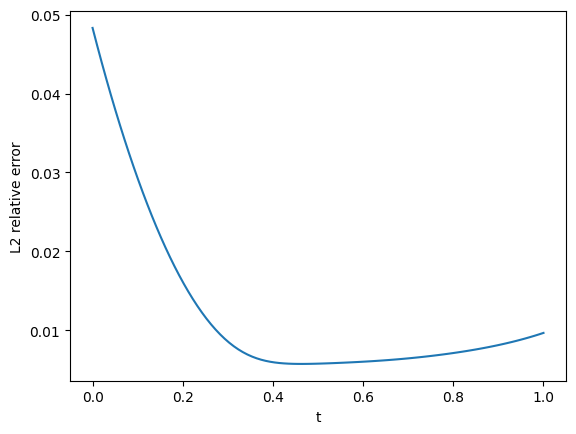

In [16]:
# compute the L2 relative error between the true solution and the predicted solution

rel_l2_errors = []

for t in range(100):
    x = geom.uniform_points(256, True)
    t = np.full(256, t/100)
    x = np.hstack((x, t.reshape(-1, 1)))
    y_pred = model.predict(x)

    y_sol = func(x)

    # collect the relative L2 errors in a list
    rel_l2_errors.append(dde.metrics.l2_relative_error(y_sol, y_pred))


# plot the relative L2 errors

x = np.linspace(0, 1, 100)
plt.plot(x, rel_l2_errors)
plt.xlabel("t")
plt.ylabel("L2 relative error")
plt.show()

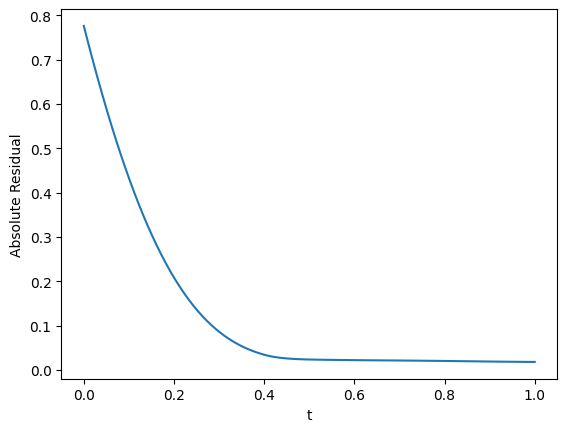

In [17]:
# compute the absolute residuals, i.e. the deviation from the PDE

absolute_residual = []

for t in range(100):
    x = geom.uniform_points(256, True)
    t = np.full(256, t/100)
    X = np.hstack((x, t.reshape(-1, 1)))

    f = model.predict(X, operator=pde)
    absolute_residual.append(np.mean(np.absolute(f)))


# plot the absolute residuals

x = np.linspace(0, 0.01 * 100, 100)
plt.plot(x, absolute_residual)
plt.xlabel("t")
plt.ylabel("Absolute Residual")
plt.show()

In [ ]:
mean_residual_inter = []
mean_residual_extra = []

l2_error_inter = []
l2_error_extra = []

In [ ]:
# set up the model

layer_size = [2] + [50] * 5 + [1]
activation = "sin"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.0001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.084894 s

'compile' took 1.044982 s



In [ ]:
# record mean residuals and l2-residuals over training epochs for t in [0, 1]

def create_data(t):
    x = geom.uniform_points(256, True)
    t = np.full(256, t/100)
    X = np.hstack((x, t.reshape(-1, 1)))
    return X

for i in range(100):
    model.train(iterations=1000)

    y_pred = np.array([model.predict(create_data(t)) for t in range(100)])
    y_sol = np.array([func(create_data(t)) for t in range(100)])
    # f = np.array([model.predict(create_data(t), operator=pde) for t in range(100)])

    # mean_residual_inter.append(np.mean(np.absolute(f)[:12800]))
    l2_error_inter.append(dde.metrics.l2_relative_error(y_sol[:50, :, :], y_pred[:50, :, :]))

    # mean_residual_extra.append(np.mean(np.absolute(f)[12800:]))
    l2_error_extra.append(dde.metrics.l2_relative_error(y_sol[50:, :, :], y_pred[50:, :, :]))

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.07e+01, 3.10e-02, 6.45e-01]    [2.52e+01, 3.10e-02, 6.45e-01]    [1.16e+00]    
1000      [1.99e-02, 5.08e-03, 6.11e-04]    [2.30e-02, 5.08e-03, 6.11e-04]    [6.09e-02]    

Best model at step 1000:
  train loss: 2.56e-02
  test loss: 2.87e-02
  test metric: [6.09e-02]

'train' took 6.103838 s

Training model...

Step      Train loss                        Test loss                         Test metric   
1000      [1.99e-02, 5.08e-03, 6.11e-04]    [2.30e-02, 5.08e-03, 6.11e-04]    [6.09e-02]    
2000      [5.41e-03, 4.57e-03, 7.05e-04]    [6.99e-03, 4.57e-03, 7.05e-04]    [6.06e-02]    

Best model at step 2000:
  train loss: 1.07e-02
  test loss: 1.23e-02
  test metric: [6.06e-02]

'train' took 2.846064 s

Training model...

Step      Train loss                        Test loss                         Test metric   
2000      [5.41e-03,

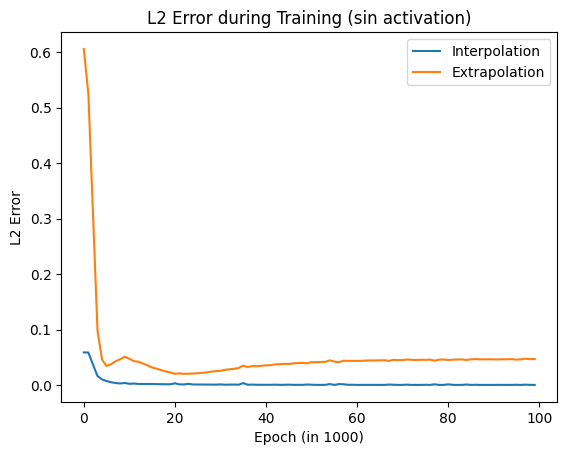

In [ ]:
# plot the mean residual in interpolation and extrapolation against the training epochs

plt.plot([*range(100)], l2_error_inter, label="Interpolation")
plt.plot([*range(100)], l2_error_extra, label="Extrapolation")

plt.legend()
plt.title("L2 Error during Training (sin activation)")
plt.xlabel("Epoch (in 1000)")
plt.ylabel("L2 Error")
plt.show()